In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import random
import csv
import os
import math
import numpy as np
from tqdm import tqdm
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
traindf = pd.read_pickle("./pickles/df_small_train.pkl")
testdf = pd.read_pickle("./pickles/df_small_test.pkl")

# run for a very small dataset for testing
# traindf = pd.read_pickle("./pickles/df_verysmall_train_test_yk.pkl")


# run if you want to use the whole train/test dataset
# traindf = pd.read_csv("data/training_set_VU_DM.csv")
traindf.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
1196703,79994,2013-01-03 13:23:33,29,132,NaN,NaN,219,2990,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1196704,79994,2013-01-03 13:23:33,29,132,NaN,NaN,219,4256,4,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,322.31,1
1196705,79994,2013-01-03 13:23:33,29,132,NaN,NaN,219,6427,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,28.0,0,NaN,0
1196706,79994,2013-01-03 13:23:33,29,132,NaN,NaN,219,8289,4,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1196707,79994,2013-01-03 13:23:33,29,132,NaN,NaN,219,13668,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [3]:
def competitors(df):
    """
    Make a new column in the dataframe (competitor_bool) for when there 
    exists a competitor and there are available rooms.
    1 is True, 0 is False.
    """
    competitor_bools = []
    availability_bools = []
    
    # Columns for existing competitors
    compare_cols = ["comp1_rate", "comp2_rate", "comp3_rate", "comp4_rate", "comp5_rate",
                "comp6_rate", "comp7_rate", "comp8_rate"]
    
    # Columns for room availability
    availability_cols = ["comp1_inv", "comp2_inv", "comp3_inv", "comp4_inv", "comp5_inv", 
                        "comp6_inv", "comp7_inv", "comp8_inv"]

    for index, row in df.iterrows():
        comp_bool = 0
        available = 0

        # Check for a combination of competitor price and room-availability. 
        for competitor, availability in zip(compare_cols, availability_cols):
            if row[competitor] == 1: # and row[availability] == 1: TODO!!!
                comp_bool = 1
            if row[availability] == 1:
                available = 1
        
        competitor_bools.append(comp_bool)
        availability_bools.append(available)
        
    # Append list of bools to new column
    df["competitor_bool"] = competitor_bools
    df["availability_bools"] = availability_bools
    
    return df

In [4]:
def visitor_history(df):
    """
    Add column that tells us whether someone has visited a hotel before.
    Column name = total_visited; 1 is True, 0 is False.
    """
    
    # Get none-missing values
    hist_starrating = df.visitor_hist_starrating.isna()
    hist_adr = df.visitor_hist_adr_usd.isna()

    # Dit kan waarschijnlijk veel mooier en sneller maar het werkt...
    total_visited = []
    for index, row in df.iterrows():
        if hist_starrating[index] or hist_adr[index]:
            visited = 0
        else:
            visited = 1
        total_visited.append(visited)

    df["visited_before"] = total_visited
    
    return df

In [5]:
def price_quality(df):
    """
    Add a column of ratio price/quality to the DataFrame.
    """
    price_quality = []
    
    # Check for missing values
    for index, row in df.iterrows():
        price, quality =  row["price_usd"],  row["prop_starrating"]
        if price and quality:
            ratio = price / quality
        else:
            ratio = None
        price_quality.append(ratio)
        
    df["price_quality"] = price_quality
    
    # Replace missing values with median
    df["price_quality"].fillna((df["price_quality"].median()), inplace=True)
    
    return df 

In [ ]:
def price_category(df):
    """
    Add a column of categories of price_usd and a column
    that corrected price for number of nights.
    Preprocessing of quantile cut showed that categories are:
    [(6.0889999999999995, 69.0] < (69.0, 90.0] < (90.0, 110.0] 
    < (110.0, 136.0] < (136.0, 170.077] < (170.077, 239.0] < (239.0, 554655.0]]
    
    """
    
    # Correct for number of nights ad add as new column
    df["price_correction"] = df["price_usd"] / df["srch_length_of_stay"]
    
    # Replace missing values
    df["price_correction"].fillna((df["price_correction"].median()), inplace=True)
    df["price_usd"].fillna((df["price_usd"].median()), inplace=True)
    
    # Make a new column of price categories
    df['PriceBand'] = pd.qcut(df["price_correction"], 7, labels=np.arange(1,8))
    
    return df

1196703    4.47
1196704    4.62
1196705    4.01
1196706    4.41
1196707    3.14
1196708    4.78
1196709    4.43
1196710    3.40
1196711    4.79
1196712    4.68
Name: prop_location_score1, dtype: float64

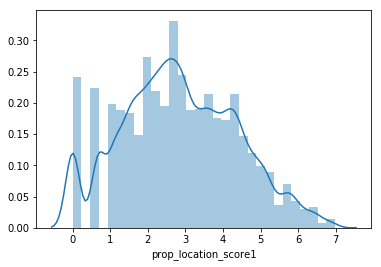

In [34]:
sns.distplot(traindf['prop_location_score1'], label="prop_location_score1", bins=30)
# print(traindf['prop_location_score1'].isna().sum()/len(traindf))
# traindf['prop_location_score1'].head(10)

In [23]:
def process_remaining_cols(df):
    """
    Add some remaining (and interesting columns) to the dataframe.
    """
    
    # Replace missing values with median
    df["prop_brand_bool"].fillna((df["prop_brand_bool"].median()), inplace=True)
    df["random_bool"].fillna((df["random_bool"].median()), inplace=True)
    
    # Boolians
    df["prop_location_score1"].fillna((df["prop_location_score1"].mean()), inplace=True)
    df["prop_location_score2"].fillna((df["prop_location_score2"].mean()), inplace=True)
        
     # Replace missing values with mean
    df["promotion_flag"].fillna((df["promotion_flag"].mean()), inplace=True)
    
    return df

In [24]:
def add_score(df):
    """
    Add a score 
    """
    if df["booking_bool"] == 1 or df["click_bool"] == 1:
        score = 1
    else:
        score = 0
    return score


def preprocessing(traindf, dollarprice=True):
    traindf = competitors(traindf)
    traindf = visitor_history(traindf)
    traindf = price_quality(traindf)
    traindf = price_category(traindf)
    traindf = process_remaining_cols(traindf)
    
    # Add relevant columns
    df = traindf[["prop_id", "srch_id", "position", "price_quality", 
                  "competitor_bool", "availability_bools", "visited_before", 
                  "click_bool", "booking_bool", "PriceBand", 
                  "promotion_flag", "prop_brand_bool", "random_bool",
                  "prop_location_score1", "prop_location_score2"]]
    
    return df

In [25]:
# Oh jit kan niet met pandas Series werken, moet omgeschreven worden naar np arrays
# @jit(nopython=True)
df = preprocessing(traindf)
df.head(5)

,prop_id,srch_id,position,price_quality,competitor_bool,availability_bools,visited_before,click_bool,booking_bool,PriceBand,promotion_flag,prop_brand_bool,random_bool
1249064,4500,83595,13,51.333333,0,0,0,0,0,4,0,1,0
1249065,14603,83595,27,45.000000,0,0,0,0,0,2,0,1,0
1249066,19960,83595,19,45.000000,0,0,0,0,0,2,0,1,0
1249067,24606,83595,28,29.500000,0,0,0,0,0,2,0,1,0
1249068,27481,83595,10,57.333333,0,0,0,0,0,4,0,1,0


In [26]:
df["price_quality"] = df.price_quality.astype(np.float32)
print(df.dtypes)
print()

if df.isnull().sum().sum() != 0:    
    print("\x1b[31mMissing values: \'\x1b[0m")
    print(df.isnull().sum())
else:
    print("\x1b[31mNo missing values!! :D \'\x1b[0m")

prop_id                  int64
srch_id                  int64
position                 int64
price_quality          float32
competitor_bool          int64
availability_bools       int64
visited_before           int64
click_bool               int64
booking_bool             int64
PriceBand             category
promotion_flag           int64
prop_brand_bool          int64
random_bool              int64
dtype: object

No missing values!! :D '


## Totale dataset zonder missende waardes, hier kan RandomForestClassifier op gerund worden

In [29]:
filename = "./pickles/df_small_clean.pkl"
if not os.path.exists(filename):
    df.to_pickle(filename)

df.describe()

,prop_id,srch_id,position,price_quality,competitor_bool,availability_bools,visited_before,click_bool,booking_bool,promotion_flag,prop_brand_bool,random_bool
count,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000
mean,71092.730637,160507.023256,16.762993,46.410301,0.161780,0.099090,0.077654,0.044287,0.028918,0.234985,0.634580,0.281496
std,40120.359438,95166.467890,10.370876,29.084732,0.368286,0.298813,0.267654,0.205753,0.167593,0.424032,0.481596,0.449775
min,119.000000,65.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36956.000000,83202.000000,8.000000,30.135000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,71026.000000,150675.000000,16.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,105165.000000,249343.000000,26.000000,54.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,140795.000000,330595.000000,39.000000,524.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
y = df["prop_id"]
X = df.drop("prop_id", axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [12]:
# Fit model on whole dataset
rfc = RandomForestClassifier(n_jobs=1)
model = rfc.fit(X_train, y_train)
predictions = model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [13]:
X_test["predictions"] = predictions
X_test.head(10)

pred_groups = X_test.groupby('srch_id').agg({'position':lambda x: list(x)})
pred_groups

,position
srch_id,
65,"[15, 14, 29, 30, 37, 3, 36, 8]"
2050,"[24, 9, 19]"
2625,"[4, 26, 16, 1, 7]"
3927,"[18, 19]"
7707,"[13, 36, 28, 27, 25, 24, 20, 7]"
...,...
322659,"[27, 12, 13, 9, 26, 7, 8]"
327160,"[18, 6, 4]"
329266,"[16, 14, 21, 20, 1, 13]"


In [14]:
rank_pred_groups   = X.groupby('srch_id').agg({'position':lambda x: list(x)})

# Get unique srchids to group by
unique_srchid = X.srch_id.unique()